# **Milestone-3, Deep Learning Notebook with GRU**

**In accordance with Milestone #3, a Gated Recurrent Unit (GRU) was implemented to predict the demand for end stations using the aforementioned 16 features. Models with distinct hyperparameters were trained and evaluated.**

**The GRU model was chosen due to its aptness for handling sequential data, capturing temporal dependencies effectively, and learning patterns from historical sequences. **As a variant of recurrent neural networks (RNNs), the Gated Recurrent Unit (GRU) is specifically designed to address the challenge of learning long-range dependencies within sequential data. **Consequently, the GRU model was employed for the task of predicting demand for end stations in the bike-sharing dataset. **

In [ ]:
# Import necessary library
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
path1= f'/content/drive/My Drive/IE434_Deep_Learning/Data_extraction/merged_pkl_data_file_original.pkl'
df = pd.read_pickle(path1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,rideable_type,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_month,stop_month,start_day_of_week,stop_day_of_week,start_hour,end_hour,tripduration_minute
0,classic_bike,Mama Johnson Field - 4 St & Jackson St,South Waterfront Walkway - Sinatra Dr & 1 St,0.755607,0.747216,0.400846,0.304860,Customer,3,3,4,4,15,15,-0.033168
1,electric_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,4,4,16,16,-0.037164
2,electric_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,6,6,17,17,-0.021181
3,classic_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,6,6,15,15,-0.029172
4,classic_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,4,4,12,12,-0.013190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528299,electric_bike,Madison St & 1 St,Columbus Dr at Exchange Pl,0.665912,0.758533,0.311868,0.279800,Customer,9,9,4,4,21,22,-0.013190
1528300,classic_bike,Monmouth and 6th,Bergen Ave & Stegman St,0.394022,0.612992,0.266324,0.011277,member,9,9,6,6,17,18,-0.009194
1528301,electric_bike,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,member,9,9,2,2,16,16,-0.041159
1528302,classic_bike,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,member,9,9,1,1,11,11,-0.045155


In [ ]:
# Group by start_day_of_week, start_hour, and end_station_name and calculate demand
grouped_df = df.groupby(['start_day_of_week', 'start_hour', 'end_station_name']).size().reset_index(name='demand')

# Merge the grouped information back to the original DataFrame based on the groupby columns
result_df = pd.merge(df, grouped_df, on=['start_day_of_week', 'start_hour', 'end_station_name'], how='left')


In [ ]:
result_df

,rideable_type,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_month,stop_month,start_day_of_week,stop_day_of_week,start_hour,end_hour,tripduration_minute,demand
0,classic_bike,Mama Johnson Field - 4 St & Jackson St,South Waterfront Walkway - Sinatra Dr & 1 St,0.755607,0.747216,0.400846,0.304860,Customer,3,3,4,4,15,15,-0.033168,537
1,electric_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,4,4,16,16,-0.037164,631
2,electric_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,6,6,17,17,-0.021181,565
3,classic_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,6,6,15,15,-0.029172,605
4,classic_bike,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,member,3,3,4,4,12,12,-0.013190,414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521595,electric_bike,Madison St & 1 St,Columbus Dr at Exchange Pl,0.665912,0.758533,0.311868,0.279800,Customer,9,9,4,4,21,22,-0.013190,147
1521596,classic_bike,Monmouth and 6th,Bergen Ave & Stegman St,0.394022,0.612992,0.266324,0.011277,member,9,9,6,6,17,18,-0.009194,24
1521597,electric_bike,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,member,9,9,2,2,16,16,-0.041159,147
1521598,classic_bike,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,member,9,9,1,1,11,11,-0.045155,82


In [ ]:
#Perform one-hot encoding for each categorical column
df_one_hot = pd.get_dummies(result_df, columns=['rideable_type', 'member_casual' ])

In [ ]:
# Assuming you have a DataFrame 'df' with the specified columns
columns_to_normalize = ['demand']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max normalization to the specified columns
df_one_hot[columns_to_normalize] = scaler.fit_transform(df_one_hot[columns_to_normalize])

In [ ]:
df_one_hot

,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,start_month,stop_month,start_day_of_week,stop_day_of_week,start_hour,end_hour,tripduration_minute,demand,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike,member_casual_Customer,member_casual_member
0,Mama Johnson Field - 4 St & Jackson St,South Waterfront Walkway - Sinatra Dr & 1 St,0.755607,0.747216,0.400846,0.304860,3,3,4,4,15,15,-0.033168,0.257321,1,0,0,1,0
1,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,3,3,4,4,16,16,-0.037164,0.302448,0,0,1,0,1
2,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,3,3,6,6,17,17,-0.021181,0.270763,0,0,1,0,1
3,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,3,3,6,6,15,15,-0.029172,0.289966,1,0,0,0,1
4,Baldwin at Montgomery,Grove St PATH,0.353913,0.378314,0.323884,0.228441,3,3,4,4,12,12,-0.013190,0.198272,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521595,Madison St & 1 St,Columbus Dr at Exchange Pl,0.665912,0.758533,0.311868,0.279800,9,9,4,4,21,22,-0.013190,0.070091,0,0,1,1,0
1521596,Monmouth and 6th,Bergen Ave & Stegman St,0.394022,0.612992,0.266324,0.011277,9,9,6,6,17,18,-0.009194,0.011042,1,0,0,0,1
1521597,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,9,9,2,2,16,16,-0.041159,0.070091,0,0,1,0,1
1521598,4 St & Grand St,Madison St & 10 St,0.737421,0.822512,0.458187,0.264579,9,9,1,1,11,11,-0.045155,0.038886,1,0,0,0,1


In [ ]:
columns=['start_station_name',	'end_station_name', 'demand']
X = df_one_hot.drop(columns=columns)
Y = df_one_hot['demand']

Initializing the GRU model using a Gated recurrent unit and a fully connected linear layer to predict the demand for the end station with a set of hyperparameters.  

In [ ]:
# Assuming X is a DataFrame and Y is a numpy array
# Convert X to a numpy array
X = X.to_numpy()

# # Standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert Y to a torch tensor
Y = torch.Tensor(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.numpy(), test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Reshape the data for GRU input (assuming a time series structure)
X_train = X_train.view(X_train.shape[0], 1, -1)
X_test = X_test.view(X_test.shape[0], 1, -1)

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiate the model, define loss and optimizer
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 10
train1_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)  # Reshape labels to match the output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    train1_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test1_losses = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        labels = labels.view(-1, 1)
        test1_loss = criterion(outputs, labels)
        test1_losses.append(test1_loss.item() * inputs.size(0))
    test1_loss = sum(test1_losses) / len(test_loader.dataset)
    print(f'Mean Squared Error on Test Set: {test1_loss:.4f}')

Epoch [1/10], Loss: 0.0065
Epoch [2/10], Loss: 0.0010
Epoch [3/10], Loss: 0.0027
Epoch [4/10], Loss: 0.0049
Epoch [5/10], Loss: 0.0019
Epoch [6/10], Loss: 0.0023
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0009
Epoch [9/10], Loss: 0.0021
Epoch [10/10], Loss: 0.0009
Mean Squared Error on Test Set: 0.0015


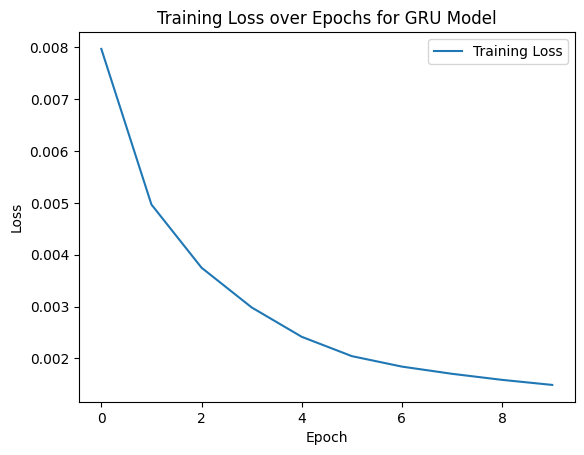

In [ ]:
# Plotting the training loss curve
plt.plot(train1_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for GRU Model')
plt.legend()
plt.show()

For the Adam optimizer, utilizing a specific set of hyperparameters, the code resulted in an MSE (Mean Squared Error) of 0.0015 on the test set for the demand prediction of the endstations, with a batch size of 32 for each batch processed. We can also see that as the number of epochs increased, the loss is in a decreasing trend.

In [ ]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model, define loss and optimizer
input_size = X_train.shape[2]
hidden_size = 100
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
# Train the model
num_epochs = 15
train2_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)  # Reshape labels to match the output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    train2_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test2_losses = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        labels = labels.view(-1, 1)
        test2_loss = criterion(outputs, labels)
        test2_losses.append(test2_loss.item() * inputs.size(0))
    test2_loss = sum(test2_losses) / len(test_loader.dataset)
    print(f'Mean Squared Error on Test Set: {test2_loss:.4f}')
        # test_outputs = test_outputs.view(-1, 1)  # Reshape test_outputs for mean_squared_error
        # mse = mean_squared_error(Y_test, test_outputs.numpy())
        # print(f'Mean Squared Error on Test Set: {mse}')


Epoch [1/15], Loss: 0.0054
Epoch [2/15], Loss: 0.0052
Epoch [3/15], Loss: 0.0092
Epoch [4/15], Loss: 0.0122
Epoch [5/15], Loss: 0.0048
Epoch [6/15], Loss: 0.0079
Epoch [7/15], Loss: 0.0044
Epoch [8/15], Loss: 0.0090
Epoch [9/15], Loss: 0.0084
Epoch [10/15], Loss: 0.0158
Epoch [11/15], Loss: 0.0053
Epoch [12/15], Loss: 0.0122
Epoch [13/15], Loss: 0.0059
Epoch [14/15], Loss: 0.0131
Epoch [15/15], Loss: 0.0058
Mean Squared Error on Test Set: 0.0090


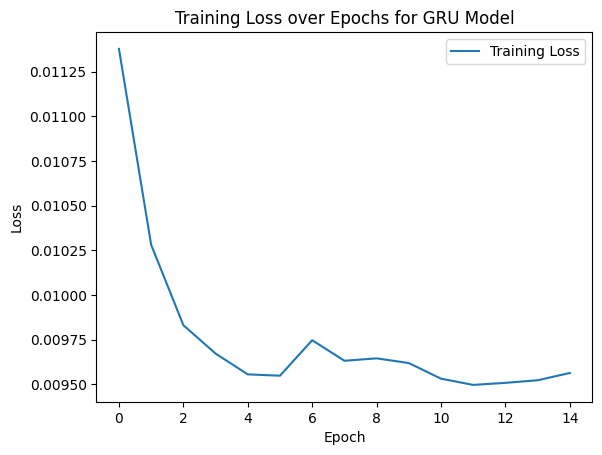

In [ ]:
# Plotting the training loss curve
plt.plot(train2_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for GRU Model')
plt.legend()
plt.show()

Utilizing a specific set of hyperparameters, the code resulted in an MSE (Mean Squared Error) of 0.0090 on the test set for the demand prediction of the endstations, with a batch size of 32 for each batch processed.

# **Conclusions**
After experimentation with various hyperparameters, the model exhibited optimal performance with specific settings: a hidden size of 50, a learning rate of 0.001, and training for 10 epochs. These hyperparameters seemed to enable the model to achieve the desired level of accuracy and convergence within a reasonable number of training iterations.